# Notes

- Maybe generating a "global" Fab model with AF2 and grafting a ABlooper predicted CDR to it?
    - Class: **pyrosetta.rosetta.protocols.antibody.AntibodyCDRGrafter**

# Workflow

**input**: PDBx2 + ms2.mzML

**output**: ...

1. Clean PDB files and merge
2. ...

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from pyrosetta import *
from pyrosetta.rosetta.core.scoring import *
from pyrosetta.rosetta.core import select
from pyrosetta.rosetta.core.select import residue_selector as selections
from pyrosetta.rosetta import protocols
from pyrosetta.rosetta.core.pack.task import operation
from pyrosetta.rosetta.protocols.antibody.residue_selector import CDRResidueSelector
from pyrosetta.rosetta.protocols.antibody import *
from pyrosetta.toolbox import *

import py3Dmol

In [2]:
def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:', 'Very low (<50)', 'Low (60)',
            'OK (70)', 'Confident (80)', 'Very high (>90)']
  plt.figure(figsize=(1, 0.1), dpi=dpi)
  ########################################
  for c in ["#FFFFFF", "#FF0000", "#FFFF00", "#00FF00", "#00FFFF", "#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  view.addModel(open(clean_pdb_file, 'r').read(), 'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop': 'b',
                  'gradient': 'roygb', 'min': 50, 'max': 90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color': 'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n, chain, color in zip(range(chains), list("ABCDEFGH"),
                               ["lime", "cyan", "magenta", "yellow", "salmon", "white", "blue", "orange"]):
      view.setStyle({'chain': chain}, {'cartoon': {'color': color}})
  if show_sidechains:
    BB = ['C', 'O', 'N']
    view.addStyle({'and': [{'resn': ["GLY", "PRO"], 'invert':True}, {'atom': BB, 'invert': True}]},
                  {'stick': {'colorscheme': f"WhiteCarbon", 'radius': 0.3}})
    view.addStyle({'and': [{'resn': "GLY"}, {'atom': 'CA'}]},
                  {'sphere': {'colorscheme': f"WhiteCarbon", 'radius': 0.3}})
    view.addStyle({'and': [{'resn': "PRO"}, {'atom': ['C', 'O'], 'invert':True}]},
                  {'stick': {'colorscheme': f"WhiteCarbon", 'radius': 0.3}})
  if show_mainchains:
    BB = ['C', 'O', 'N', 'CA']
    view.addStyle(
        {'atom': BB}, {'stick': {'colorscheme': f"WhiteCarbon", 'radius': 0.3}})

  view.setBackgroundColor('lightgray')
  view.zoomTo()
  return view

In [3]:
init('-use_input_sc -ignore_unrecognized_res \
     -ignore_zero_occupancy false -load_PDB_components false -no_fconfig')


PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2021.38+release.4d5a9693c031951766d575fca9286ed34f560779 2021-09-22T20:45:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r297 2021.38+release.4d5a969 4d5a9693c031951766d575fca9286ed34f560779 http://www.pyrosetta.org 2021-09-22T20:45:44
core.init: {0} command: PyRosetta -use_input_sc -ignore_unrecognized_res -ignore_zero_occupancy false -load_PDB_components false -no_fconfig -database /srv/data1/home/jo0348st/envs/miniconda3/envs/pyrosetta/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=1040802606 seed_offset=0 real_seed=1040802606 thread_index=0
basic.random.init_random_generator: {0} RandomGenerat

In [4]:
pdb_file = './data/top01_fab.pdb'
clean_pdb_file = './data/top01_fab_clean.pdb'
cleanATOM(pdb_file=pdb_file, out_file=clean_pdb_file)

pose = pose_from_pdb(clean_pdb_file)
original_pose = pose.clone()

core.chemical.GlobalResidueTypeSet: {0} Finished initializing fa_standard residue type set.  Created 983 residue types
core.chemical.GlobalResidueTypeSet: {0} Total time to initialize 0.884401 seconds.
core.import_pose.import_pose: {0} File './data/top01_fab_clean.pdb' automatically determined to be of type PDB
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue SER:CtermProteinFull 204
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue PRO:CtermProteinFull 419
core.conformation.Conformation: {0} Found disulfide between residues 23 88
core.conformation.Conformation: {0} current variant for 23 CYS
core.conformation.Conformation: {0} current variant for 88 CYS
core.conformation.Conformation: {0} current variant for 23 CYD
core.conformation.Conformation: {0} current variant for 88 CYD
core.conformation.Conformation: {0} Found disulfide between residues 131 190
core.conformation.Conformation: {0} current variant for 131 CYS
cor

In [5]:
pdb_info = pose.pdb_info()
nres = pose.total_residue()
seq = pose.sequence()

line_break = 50
seq_print = ''.join(
    [
        c
        if (i+1)%(line_break+1)!=0
        else '\n'
        for i, c in enumerate(seq)
    ]
)

print(pdb_info)
print(f'Residues [n={nres}]\n{seq_print}')

PDB file name: ./data/top01_fab_clean.pdb
 Pose Range  Chain    PDB Range  |   #Residues         #Atoms

0001 -- 0204    L 0001  -- 0204  |   0204 residues;    03142 atoms
0205 -- 0419    H 0001  -- 0215  |   0215 residues;    03216 atoms
                           TOTAL |   0419 residues;    06358 atoms

Residues [n=419]
RIVMTQTPKFLLVSAGDRVTITCKASQSVSNDVAWYQQRPGQSPKLLIYY
SNRFTGVPDRFTGSGYGTDFTFTISSLQTEDLAVYFCQQYYSSPWTFGGG
MLEIKSSPSVTLFPPSSEELETNKATLVCTITDFYPGVVTVDWKVDGTPV
QGMETTQPSKQSNNKYMASSYLTLTARAWERHSSYSCQVTHEGHTVEKSL
EVQLQQSGPELVKPGASVKIPCKASGFIFTDYNMDWVKQSHGKSLEWIGD
NPNNGNNIYNQKFKGKATLTVDKSSSTAYMELHSLTSEDTAVYYCARGRI
MDHWGQGTSVTVSSAKTTPPSVYPLAPGSAAQTNSMVTLGCLVKGYFPEP
TVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVPSSTWPSETVTCNVAHP
SSTKVDKKIVP


In [6]:
pdb_nums = [
    (str(pdb_info.number(i)) + pdb_info.icode(i)).strip()
    for i in range(1, nres + 1)
]
chains = [pdb_info.chain(i) for i in range(1, nres + 1)]
unique_chains = set(chains)

phis = [pose.phi(i) for i in range(1, nres + 1)]
psis = [pose.psi(i) for i in range(1, nres + 1)]
omegas = [pose.omega(i) for i in range(1, nres + 1)]

sfxn = get_score_function()
sfxn(pose)

DSSP = protocols.moves.DsspMover()
DSSP.apply(pose)
ss = pose.secstruct()

core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.scoring.etable: {0} Starting energy table calculation
core.scoring.etable: {0} smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: {0} smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: {0} smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: {0} Finished calculating energy tables.
basic.io.database: {0} Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: {0} Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: {0} Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: {0} Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: {0} Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: {0} Databa

In [7]:
# TODO:
# - Change to f-strings
print(f'Secondary Structure:\n{ss}')
print('\t' + str(100. * ss.count('H') / len(ss))[:4] + '% Helical (H)')
print('\t' + str(100. * ss.count('E') / len(ss))[:4] + '% Sheet (E)')
print('\t' + str(100. * ss.count('L') / len(ss))[:4] + '% Loop (L)')

Secondary Structure:
LLLEEEELLEEELLLLLLEEEEEEELLLLLLLEEEEEELLLLLLEEEEELLLEELLLLLLLEEEEEELLEEEEEELLLLHHHLLEEEEEELLLLLLEELLLEEEELLELLEEEEELLLHHHHHHLEEEEEEEEEEEELLLLEEEEEELLEEELLLEEELLLEELLLLLEEEEEEEEEEHHHHHHLLLEEEEEEELLEEEEEEELLLEEEELLLEEELLLLLEEEEEEEELLLHHHLEEEEEEEELLLEEEEEEEELLLLLLEEELHHHELLEEEEEEHHHLEEEEEELLLLHHHLEEEEEEEELLLEEEELLLEEEEELLLLLELLEEEEELLLHHHHHLLEEEEEEEEEEEELLLLEEEEHHHLLLLLEEELLLEEELLEEEEEEEEEEELLLLLLLLLEEEEEEHHHLEEEEEELLL
	9.06% Helical (H)
	52.9% Sheet (E)
	37.9% Loop (L)


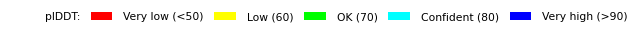

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
is_complex = False
rank_num = 1
show_sidechains = False
show_mainchains = False
color = 'lDDT'


if color == "lDDT":
  plot_plddt_legend(dpi=77.8).show()

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()

In [9]:
energies = pose.energies()
residue_energies = [
    energies.residue_total_energy(i)
    for i in range(1, nres + 1)
]

pose_hbonds = hbonds.HBondSet()

hbonds.fill_hbond_set(pose, False, pose_hbonds)

hbond_dictionary = {}

for residue in range(1, nres + 1):
    hbond_text = ''
    for hbond in range(1, pose_hbonds.nhbonds() + 1):
        hbond = pose_hbonds.hbond(hbond)
        acceptor_residue = hbond.acc_res()
        donor_residue = hbond.don_res()
        if residue == acceptor_residue or residue == donor_residue:
            # Rewrite to save as data structure and not string!
            # And skip duplicates.
            hbond_text += str(donor_residue).ljust(4) + ' ' + \
                str(pose.residue(donor_residue).atom_name(
                    hbond.don_hatm())).strip().ljust(4) + \
                ' => ' + str(acceptor_residue).ljust(4) + ' ' + \
                str(pose.residue(acceptor_residue).atom_name(
                    hbond.acc_atm())).strip().ljust(4) + \
                ' |score: ' + str(hbond.energy()) + '\n'
    hbond_dictionary[residue] = hbond_text if len(hbond_text)>1 else None

In [10]:
print('(donor residue) (donor atom) => (acceptor residue) (acceptor atom) |score')

for k, v in hbond_dictionary.items():
    if v:
        print(v)

(donor residue) (donor atom) => (acceptor residue) (acceptor atom) |score
3    H    => 26   OG   |score: -2.2658265609212607
26   H    => 3    O    |score: -0.8844541961070821

5    H    => 24   O    |score: -1.242694675726316
24   H    => 5    O    |score: -1.2480775514260543

88   H    => 6    OE1  |score: -0.6666910302374063
6    1HE2 => 86   O    |score: -0.8289538663970062
6    2HE2 => 102  OG1  |score: -0.6351671322582959

7    H    => 22   O    |score: -1.191560312472708
22   H    => 7    O    |score: -0.8517229062531277

103  H    => 9    O    |score: -1.3779261454852463

11   H    => 103  O    |score: -0.9782471726672272
105  H    => 11   O    |score: -1.0780528340971702

13   H    => 105  O    |score: -0.6563656732530452

14   H    => 17   OD2  |score: -0.9292856197305861
17   H    => 14   O    |score: -1.206619078949129

16   H    => 78   O    |score: -1.5827863514901095

14   H    => 17   OD2  |score: -0.9292856197305861
17   H    => 14   O    |score: -1.206619078949129
78 

In [11]:
ab_info = protocols.antibody.AntibodyInfo(
    pose, protocols.antibody.Kabat_Scheme, protocols.antibody.North)

enum_manager = protocols.antibody.AntibodyEnumManager()

basic.io.database: {0} Database file opened: sampling/antibodies/cluster_center_dihedrals.txt
protocols.antibody.AntibodyNumberingParser: {0} Antibody numbering scheme definitions read successfully
protocols.antibody.AntibodyNumberingParser: {0} Antibody CDR definition read successfully
antibody.AntibodyInfo: {0} Successfully finished the CDR definition
antibody.AntibodyInfo: {0} AC Detecting Regular CDR H3 Stem Type
antibody.AntibodyInfo: {0} VYYCARGRIAM
antibody.AntibodyInfo: {0} AC Finished Detecting Regular CDR H3 Stem Type: EXTENDED
antibody.AntibodyInfo: {0} AC Finished Detecting Regular CDR H3 Stem Type: Kink: 0 Extended: 1
antibody.AntibodyInfo: {0} Setting up CDR Cluster for H1
protocols.antibody.cluster.CDRClusterMatcher: {0} Length: 13 Omega: TTTTTTTTTTTTT
antibody.AntibodyInfo: {0} Setting up CDR Cluster for H2
protocols.antibody.cluster.CDRClusterMatcher: {0} Length: 9 Omega: TTTTTTTTT
antibody.AntibodyInfo: {0} Setting up CDR Cluster for H3
protocols.antibody.cluster.CDRC

In [27]:
list_dict = {chain: [] for chain in unique_chains}

view = py3Dmol.view()
view.addModel(open('./data/top01_fab_clean.pdb', 'r').read(), 'pdb')
view.setBackgroundColor('lightgrey')

for i in range(1, len(seq)+1):
    chain = pose.pdb_info().chain(i)
    residue = pose.pdb_info().number(i)

    list_dict[chain].append('')

view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
import nglview as nv

color_list = []

for i in range(1, pose.size()+1):
    region = enum_manager.antibody_region_enum_to_string(
        ab_info.get_region_of_residue(pose, i)
    )
    if region == 'framework_region':
        tmp_list = ['black', str(i)]
    else:
        cdr = enum_manager.cdr_name_enum_to_string(
            ab_info.get_CDRNameEnum_of_residue(pose, i))
        if cdr.startswith('L'):
            tmp_list = ['red', str(i)]
        elif cdr.startswith('H'):
            tmp_list = ['blue', str(i)]
        else:
            tmp_list = ['white', str(i)]
    color_list.append(tmp_list)

color_scheme = nv.color._ColorScheme(color_list, 0)

v = nv.show_rosetta(pose, default_representation=False)

v.clear()
v.add_cartoon('protein', color=color_scheme)
v

NGLWidget()

In [ ]:
# nbr_selector = selections.NeighborhoodResidueSelector()
# cdr_selector = protocols.antibody.residue_selector.CDRResidueSelector()
# cdr_selector.set_cdr(h1)

# nbr_selector.set_focus_selector(cdr_selector)
# nbr_selector.set_include_focus_in_subset(True)

# prevent_repacking_rlt = operation.PreventRepackingRLT()

# prevent_subset_repacking = operation.OperateOnResidueSubset(
#     prevent_repacking_rlt,
#     nbr_selector,
#     True
# )


In [ ]:
# cdr_res = []
# for i in select.get_residue_set_from_subset(cdr_selector.apply(pose)):
#     #print(i)
#     cdr_res.append(i)